In [99]:
#rotate and crop each tissue section in DL mask
#save rotational angle
#save bounding box coordinate and crop

In [100]:
#read json for centroid of each cell
#adjust centroid coordinates from WSI-space to crop/rotated-space
#assign cell type to each nuclei-object based on the pixel value of crop/rotated DL mask

In [127]:
import json
import pandas as pd
import pandas as pd
from PIL import Image
Image.MAX_IMAGE_PIXELS=None
import numpy as np
from skimage.measure import label
from skimage.morphology import closing, square, remove_small_objects, remove_small_holes
from skimage.transform import rotate
from math import atan2, degrees
import glob,os
from natsort import natsorted
from copy import deepcopy
import cv2
from time import time
from skimage.measure import regionprops
from matplotlib import pyplot as plt
import time

In [128]:
def rotate_image_cv2(mat, angle):
    """
    Rotates an image (angle in degrees) and expands image to avoid cropping
    """

    height, width = mat.shape[:2] # image shape has 3 dimensions
    image_center = (width/2, height/2) # getRotationMatrix2D needs coordinates in reverse order (width, height) compared to shape

    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)

    # rotation calculates the cos and sin, taking absolutes of those.
    abs_cos = abs(rotation_mat[0,0])
    abs_sin = abs(rotation_mat[0,1])

    # find the new width and height bounds
    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)

    # subtract old image center (bringing image back to origo) and adding the new image center coordinates
    rotation_mat[0, 2] += bound_w/2 - image_center[0]
    rotation_mat[1, 2] += bound_h/2 - image_center[1]

    # rotate image with the new bounds and translated rotation matrix
    rotated_mat = cv2.warpAffine(mat, rotation_mat, (bound_w, bound_h))
    return rotated_mat

In [137]:

# Opening JSON file
json = r"C:\Users\kyuha\Desktop\hovernet_rotate\21.json"
json = pd.read_json(json, orient='index')
json = pd.DataFrame(json[0].loc['nuc']).T.drop(columns=['type_prob'])
json = json[json['contour'].map(len) > 5].reset_index(drop=True)

In [138]:
msk_pth = r"C:\Users\kyuha\Desktop\hovernet_rotate\21dl.tif"
im_msk = Image.open(msk_pth)

im_pth = r"C:\Users\kyuha\Desktop\hovernet_rotate\21im.tif"
im = Image.open(im_pth)

In [139]:
#need the original dimension of the wsi image, because the json file coordinates are based on it
from openslide import OpenSlide
ndpi = OpenSlide(r"\\fatherserverdw\Q\research\images\skin_aging\wsi\21.ndpi")
(w,h) = ndpi.level_dimensions[0]

In [140]:
#create mask for all nuclei, record time
start_time = time.time()
nuc_image = np.zeros((h,w)) #need to flip h and w
for idx,ct in enumerate(json['contour']):
     cv2.fillPoly(nuc_image, pts=[np.array(ct).astype(np.int32)],  color=idx)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.9521300792694092 seconds ---


In [141]:
degrot  = [47.61, 184.13] #47.61 is wrong

In [142]:
json

,bbox,centroid,contour,type
0,"[[3519, 9945], [3536, 9954]]","[3805.1009174311926, 9671.37614678899]","[[3804, 9663], [3803, 9664], [3803, 9669], [38...",None
1,"[[3878, 9852], [3894, 9861]]","[3712.0582524271845, 10029.563106796117]","[[3711, 10022], [3711, 10023], [3710, 10024], ...",None
2,"[[1347, 16198], [1363, 16209]]","[1866.5174825174824, 15690.237762237763]","[[1864, 15683], [1863, 15684], [1863, 15685], ...",None
3,"[[1361, 16173], [1380, 16184]]","[1842.2777777777778, 15706.145833333334]","[[1841, 15697], [1840, 15698], [1839, 15698], ...",None
4,"[[1392, 16165], [1408, 16180]]","[1835.235294117647, 15736.025210084033]","[[1841, 15728], [1839, 15730], [1838, 15730], ...",None
...,...,...,...,...
47462,"[[71915, 8231], [71933, 8248]]","[71726.9574468085, 8435.685106382978]","[[71721, 8427], [71720, 8428], [71720, 8430], ...",None
47463,"[[71915, 8330], [71929, 8336]]","[71820.5294117647, 8433.558823529413]","[[71821, 8427], [71819, 8429], [71819, 8430], ...",None
47464,"[[71918, 8254], [71931, 8267]]","[71748.14634146342, 8435.796747967479]","[[71746, 8430], [71745, 8431], [71744, 8431], ...",None
47465,"[[71919, 7974], [71930, 7990]]","[71469.80952380953, 8436.07142857143]","[[71464, 8431], [71463, 8432], [71462, 8432], ...",None


In [ ]:
# Define minimum sizes of tissue objects at 1um resolution
minTA = 20000
minTAhole = 100
minDermhole = 5000
minepisize=1000
whitespace=12 #define background pixel value


msk_pth = r"C:\Users\kyuha\Desktop\hovernet_rotate\21dl.tif"
mask = Image.open(msk_pth)

im_pth = r"C:\Users\kyuha\Desktop\hovernet_rotate\21im.tif"
im = Image.open(im_pth)

dst = r"C:\Users\kyuha\Desktop\hovernet_rotate"


degrot =[47.61, 184.13]
TAbig = np.array(mask)

#label mask
(width, height) = (mask.width // 10, mask.height // 10) #downsize by 10
mask_resized = mask.resize((width, height), resample=0) #nearest interpolation to rescale
TA = np.array(mask_resized) # convert DL mask to numpy array
# separate touching tissue sections using WATERSHED segmentation
sure_foreground = (2 < TA) & (TA < whitespace - 1) #define tissue section conservatively by removing corneum==1, and removing fat==12, so this foreground does not touch adjacent tissue section for sure.

sure_fg = closing(sure_foreground, square(3))  # 13sec
# remove small objects not connected to the tissue section
sure_fg = remove_small_objects(sure_fg, min_size=minTA, connectivity=2)  # 6sec

sure_fg = remove_small_holes(sure_fg, area_threshold=minTAhole).astype(np.uint8)

bw = closing(TA < whitespace, square(3))  # 12 is background
bw = remove_small_objects(bw, min_size=minTA, connectivity=2)
bw = remove_small_holes(bw, area_threshold=minTAhole)
# morphological opening : erosion followed by an dilation to remove small objects
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(bw.astype(np.uint8), cv2.MORPH_OPEN, kernel, iterations=2)  # 2sec
# dilate to be more lenient in defining tissue section area
sure_bg = cv2.dilate(opening, kernel, iterations=3)

unknown = cv2.subtract(sure_bg, sure_fg).astype(np.bool)

sure_fg_label = label(sure_fg).astype(np.int32)
sure_fg_label = sure_fg_label + 1 #objects are 2~N
sure_fg_label[unknown] = 0 #middle ground is 0

#get labeled image
TAbgr = cv2.cvtColor(TA, cv2.COLOR_GRAY2BGR) #convert downsized DL mask to BGR color channel
label_image = cv2.watershed(TAbgr, sure_fg_label) #apply watershed using fg,bg,mg, defined mask

# iterate each section
epi = (TA == 1) | (TA == 2)
derm = (2 < TA) & (TA < whitespace)
derm = remove_small_holes(derm, area_threshold=minDermhole)

epi2 = epi & ~derm
epi2 = remove_small_objects(epi2, min_size=minepisize, connectivity=2)

In [ ]:
sec = []
numsecmax = np.max(label_image)

In [151]:
im_msk.size

(33495, 8142)

In [152]:
ndpi.level_dimensions[0]

(73728, 17920)

In [155]:
enlarge_label_image =  cv2.resize(label_image.astype("uint8"), dsize=(73728, 17920), interpolation=cv2.INTER_CUBIC)

#for cent in (json['centroid']):
    #if(cent)

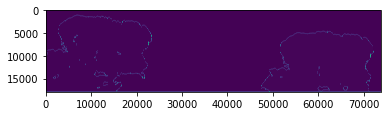

In [156]:
plt.imshow(enlarge_label_image)

In [ ]:
for numsec in range(1,numsecmax):
    msktmp = label_image == numsec+1
    plt.imshow(msktmp)

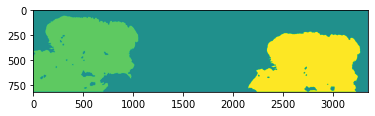

In [147]:
plt.imshow(label_image)

In [ ]:

#
for numsec in range(1,numsecmax):
    print('section N: ', numsec, '/', numsecmax-1)
    #find out which nuclei belongs to which section

    deg = degrot[numsec-1]
    msktmp = label_image == numsec+1
    stats = regionprops(msktmp.astype(np.uint8))
    centroid = stats[0].centroid #NOTE:this returns (y,x)!!
    cent = (10*centroid[1],10*centroid[0])

    TAtmp = deepcopy(TAbig)
    mskbig = cv2.resize(msktmp.astype(np.uint8), TAtmp.shape[::-1], interpolation=cv2.INTER_NEAREST)
    # delete non-ROI from scaled up ROI
    kernel = np.ones((20, 20), np.uint8)
    mskbig = cv2.dilate(mskbig, kernel, iterations=3)
    TAtmp[mskbig == 0] = 0  #1sec

    imcrop = np.multiply(np.array(im),TAtmp[..., None].astype('bool'))

    #crop it, rotate it, and then crop it again (or else the matrix is too big for cv2 to process)
    [xt, yt] = np.where(imcrop[:,:,0]) #tissue mask to point clouds,don't know why there are three arrays
    imrot = imcrop[np.min(xt):np.max(xt), np.min(yt):np.max(yt)]
    imrot2 = rotate_image_cv2(imrot, deg)

    [xt, yt] = np.where(imrot2[:,:,0]) #tissue mask to point clouds,don't know why there are three arrays
    imrot3 = imrot2[np.min(xt):np.max(xt), np.min(yt):np.max(yt)]
    imrot3[imrot3==0] = 235

    #repeat the step above for the mask
    [xt, yt] = np.where(TAtmp[:,:])
    mskrot =TAtmp[np.min(xt):np.max(xt), np.min(yt):np.max(yt)]
    mskrot2 = rotate_image_cv2(mskrot, deg)

    [xt, yt] = np.where(mskrot2)
    mskrot3 = mskrot2[np.min(xt):np.max(xt), np.min(yt):np.max(yt)]

    # if dermis is above epidermis, flip it
    [xt, yt] = np.where(mskrot3)
    [xt2, yt2] = np.where((mskrot3 == 1) | (mskrot3 == 2))
    if np.mean(xt) - np.mean(xt2) < 0:
        imrot3 = np.rot90(np.rot90(imrot3))
        mskrot3 = np.rot90(np.rot90(mskrot3))


    imrot3[imrot3 == 0] = 235  # assign whitespace value to background
    mskrot3[mskrot3 == 0] = whitespace

    #Image.fromarray(imrot3.astype('int8')).save(
            #os.path.join(dst, '{}im_sec{:02d}.png'.format("21", numsec)))

    #Image.fromarray(mskrot3.astype('int8')).save(
            #os.path.join(dst, '{}msk_sec{:02d}.png'.format("21", numsec)))
